In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from numba import njit
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from scipy.stats import kstest
import numpy.random

In [2]:
data_path = Path('data')

In [3]:
df_train = pd.read_csv(data_path / 'train.csv')

In [4]:
df_test = pd.read_csv(data_path / 'test.csv')

In [5]:
df_train.rename(columns={"opened_position_qty ": "opened_position_qty"}, inplace=True)
df_test.rename(columns={"opened_position_qty ": "opened_position_qty"}, inplace=True)

In [6]:
y, df = df_train.pop('y'), df_train

In [7]:
df.head(10)

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
0,0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,...,8,1,6,14,6,6,1,1,10,2
1,1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,...,7,6,11,1,6,1,4,4,1,13
2,2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,...,3,1,4,21,12,1,16,10,4,9
3,3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,...,10,13,12,2,4,2,7,1,2,11
4,4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,...,14,12,2,2,4,1,3,1,11,15
5,5,3843.6,3844.2,12.0,17.0,29.0,-5,3843.8,3843.4,3843.2,...,1,6,1,2,17,1,12,15,10,3
6,6,3843.6,3844.3,2.0,37.0,39.0,-34,3843.8,3843.4,3843.2,...,1,7,1,1,17,11,15,10,3,9
7,7,3844.8,3843.5,4.0,24.0,28.0,-20,3843.2,3843.0,3842.8,...,1,2,17,1,12,2,12,7,16,10
8,8,3843.4,3843.7,2.0,30.0,32.0,-28,3843.4,3843.2,3843.0,...,1,1,3,17,1,1,2,6,8,18
9,9,3844.0,3843.4,3.0,12.0,15.0,-9,3843.0,3842.8,3842.6,...,1,17,3,12,2,7,1,2,7,8


In [8]:
df_test.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
0,592380,5178.4,5178.3,1.0,11.0,12.0,-10,5178.2,5178.0,5177.8,...,3,16,3,1,1,1,4,1,5,2
1,592381,5133.0,5132.9,1.0,0.0,1.0,1,5132.8,5132.6,5132.4,...,1,2,2,1,10,4,8,1,1,1
2,592382,5177.4,5178.0,2.0,0.0,2.0,2,5177.2,5176.8,5176.6,...,8,18,1,1,6,7,4,1,2,5
3,592383,5093.6,5093.9,0.0,2.0,2.0,-1,5093.2,5093.0,5092.8,...,8,5,4,3,1,1,1,11,6,2
4,592384,5189.2,5189.2,NaN,NaN,0.0,0,5188.8,5188.6,5188.4,...,1,5,1,3,3,3,2,1,3,4


In [9]:
def best_bid_quote(data):
    return data.bid1 * data.bid1vol

def best_ask_quote(data):
    return data.ask1 * data.ask1vol

class Formulas:

    def vimba(data):
        return data.bid1vol / (data.bid1vol + data.ask1vol)

    def quote_vimba(data):
        bid_quote = best_bid_quote(data)
        ask_quote = best_ask_quote(data)
        return bid_quote / (bid_quote + ask_quote)

    def spread(data):
        return data.ask1 - data.bid2

    def last_take_ask_diff(data):
        return data.ask1 - data.last_price

    def last_take_bid_diff(data):
        return data.last_price - data.bid1

class Features:
    def compute(data):
        feats = [feat(data) for feat in Formulas.__dict__.values() if callable(feat)]
        cols = [feat.__name__ for feat in Formulas.__dict__.values() if callable(feat)]
        feats = pd.concat(feats, axis=1)
        feats.columns = cols
        return feats

In [10]:
feats = Features.compute(df)
feats.head()

,vimba,quote_vimba,spread,last_take_ask_diff,last_take_bid_diff
0,0.571429,0.571403,0.8,0.4,0.0
1,0.875000,0.874977,1.0,1.0,-0.2
2,0.750000,0.749951,1.2,0.8,0.2
3,0.833333,0.833304,1.0,0.0,0.8
4,0.933333,0.933324,1.0,0.2,0.4


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [27]:
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=0.1, shuffle=False)
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]
X_test.dropna(inplace=True)
y_test = y_test.loc[X_test.index]

lm_clf = LogisticRegression()
lm_clf.fit(X_train, y_train)

y_test_pred_proba = lm_clf.predict_proba(X_test)[:, 1]
y_train_pred_proba = lm_clf.predict_proba(X_train)[:, 1]

print('train score:', roc_auc_score(y_train, y_train_pred_proba))
print('test score:', roc_auc_score(y_test, y_test_pred_proba))

train score: 0.6454834429040114
test score: 0.6302267834866574


In [34]:
boost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.15,
    depth=8,
    eval_metric='AUC',
    logging_level='Silent',
    thread_count=2,
    task_type='CPU',
    has_time=True
)

In [35]:
boost_clf.fit(X_train, y_train, eval_set=(X_test, y_test))

In [36]:
roc_auc_score(y_train, boost_clf.predict_proba(X_train)[:, 1])

0.6573366490468053

In [37]:
roc_auc_score(y_test, boost_clf.predict_proba(X_test)[:, 1])

0.6353948393463086

In [210]:
d1 = quote_vimba(df)
d2 = quote_vimba(df_test)

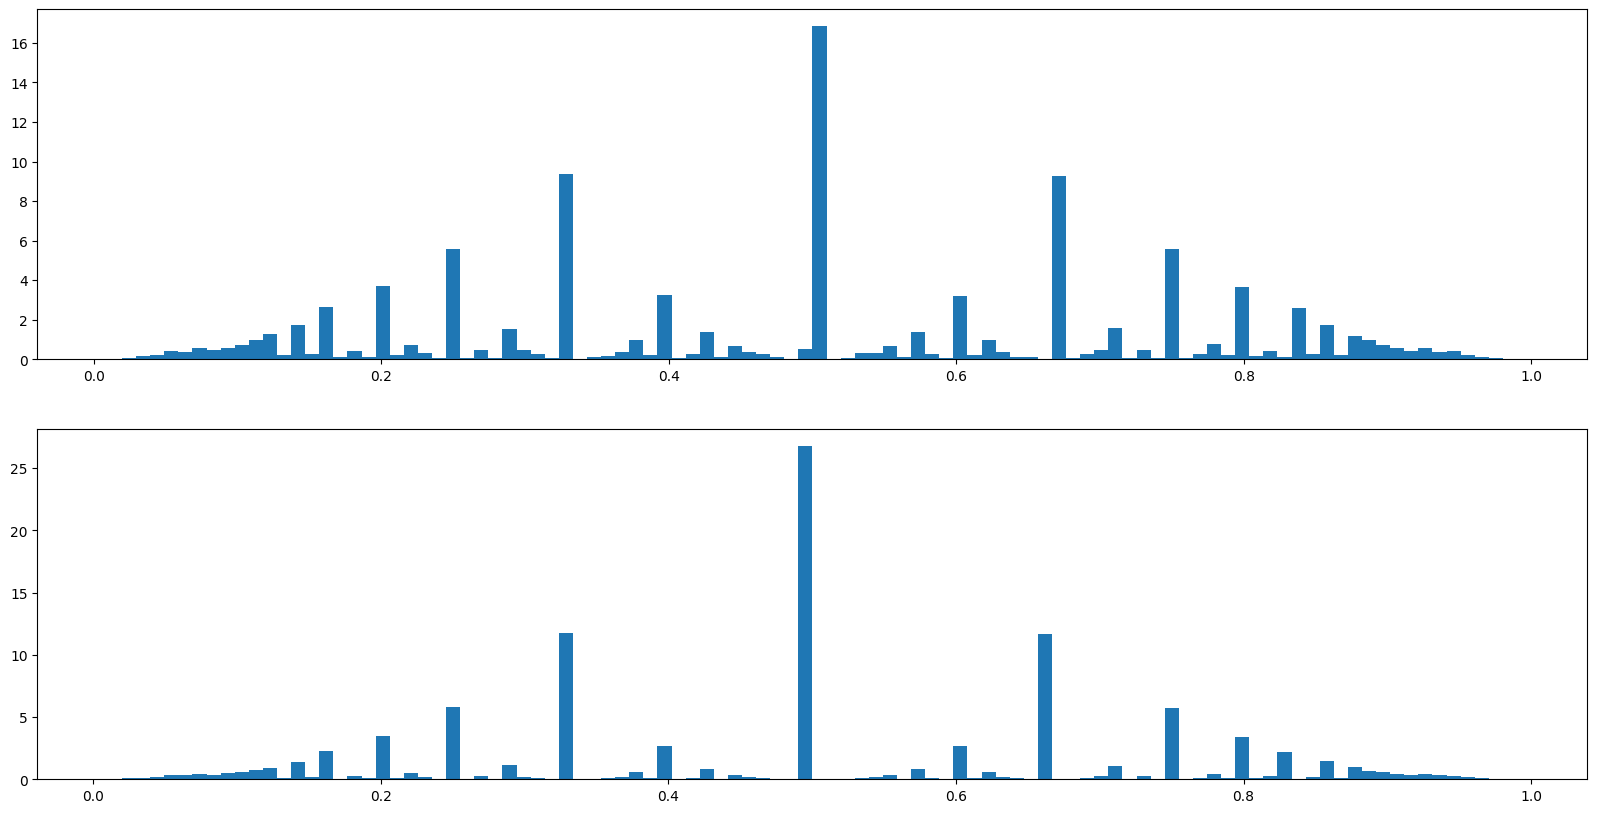

In [211]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2)
ax[0].hist(d1, bins=100, density=True)
ax[1].hist(d2, bins=100, density=True)
pass

In [212]:
kstest(d1, d2).pvalue

0.0